In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from typing import List, Union

In [2]:
sns.set(rc={'figure.figsize':(11, 7)})

In [3]:
# Seteamos la misma seed para torch, numpy, etc
# para tratar de reproducir los mismos resultados
seed = 1234

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Descargo el dataset del repositorio
!wget https://raw.githubusercontent.com/ankandrew/Iris/master/iris.csv

--2021-04-05 03:05:32--  https://raw.githubusercontent.com/ankandrew/Iris/master/iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3975 (3.9K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   3.88K  --.-KB/s    in 0s      

2021-04-05 03:05:32 (71.1 MB/s) - ‘iris.csv’ saved [3975/3975]



In [5]:
# Cargamos el dataset en un DataFrame
df = pd.read_csv('./iris.csv', delimiter=',')

## Inspeccionando la Data

In [6]:
# Inspeccionamos una muestra aleatoria
df.sample(n=5)

,sepal.length,sepal.width,petal.length,petal.width,variety
91,6.1,3.0,4.6,1.4,Versicolor
63,6.1,2.9,4.7,1.4,Versicolor
103,6.3,2.9,5.6,1.8,Virginica
6,4.6,3.4,1.4,0.3,Setosa
59,5.2,2.7,3.9,1.4,Versicolor


In [7]:
# Revisamos el tipo de dato de X e y
# También verificamos que no haya nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [8]:
# Analizamos las estadísticas de las X/inputs/features
df.iloc[:, :-1].describe()

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


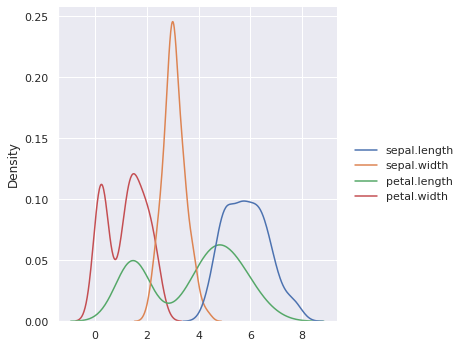

In [9]:
# Exploramos la distribución de las distintas features
sns.displot(df, kind="kde")

In [10]:
# Verificamos la cantidad de cada clase para ver si hay algún imbalance
n_classes = df['variety'].value_counts()
n_classes

Setosa        50
Virginica     50
Versicolor    50
Name: variety, dtype: int64

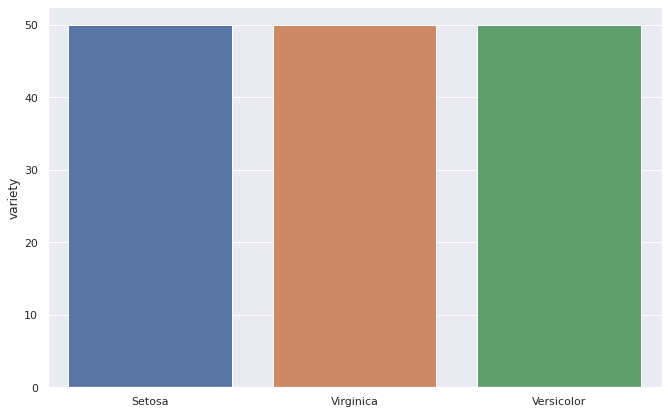

In [11]:
# Vemos que no haces falta ponderar una clase más que otra
sns.barplot(x = n_classes.index, y = n_classes)

In [12]:
# Muestro la correlación de las features
# Podemos probar sacar petal.width ya que
# está altamente correlacionada con petal.length
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,sepal.length,sepal.width,petal.length,petal.width
sepal.length,1.000000,-0.117570,0.871754,0.817941
sepal.width,-0.117570,1.000000,-0.428440,-0.366126
petal.length,0.871754,-0.428440,1.000000,0.962865
petal.width,0.817941,-0.366126,0.962865,1.000000


## Preprocesando X e Y

In [13]:
# Es importante normalizar las features/x. Por ejemplo, en el caso de los dos
# modelos que vamos a probar:

# KNN: La clasificación de una nueva entrada va a depender de los top `k`
# vecinos más cercanos. Si la feature `a` tiene una escala mucho más chica que la
# de `b`, esta última va atribuir mucho más a la función de distancia que `a`

# Neural Nets: Digamos que tenemos la ""red"" y=w1*x1+w2*x2, Si la feature x1
# toma valores entre [0, 100000] y x2 toma valores entre [0, 1], vamos a querer
# actualizar w1 mucho mas que w2 por la magnitud de x1. Por ejemplo, si nuestro
# vector gradiente es g(w1,w2)=[dL/dw1, dL/dw2] y para nuestro modelo con una
# función de coste del error cuadrático obtenemos que g(w1,w2)=[2*x1*s, 2*x2*s]
# la actualización de los pesos es proporcional al dato de entrada, por lo que
# vamos a actualizar más w1.

scaler = MinMaxScaler(feature_range=(0, 1))
# Seleccionamos las primeras 4 features, excluyendo el target/label
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

In [14]:
# Verificamos el rango
assert (df[df.columns[:-1]].max() == 1).all() and (df[df.columns[:-1]].min() == 0).all()

In [15]:
# Convertimos las clases de str -> int, con el rango [0, numero_clases-1]
label_enc = LabelEncoder()
df['variety'] = label_enc.fit_transform(df['variety'])

In [16]:
# Verificamos
df.iloc[:,-1].sample(n=5)

76     1
105    2
73     1
117    2
115    2
Name: variety, dtype: int64

In [17]:
# Convierto de double a float, porque los weights/biases
# en PyTorch la vamos a usar de tipo float32
for col in df.columns[:-1]:
    df[col] = df[col].astype('float32')

In [18]:
'''
indice -> clase

0 -> Setosa
1 -> Versicolor
2 -> Virginica
'''

label_enc.classes_

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

## Train/Test set

In [19]:
# Separo el dataset en: 70% train y 30% test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.3, random_state=1111)

In [20]:
print(f'len de train {len(x_train.index)}')
print(f'len de test {len(x_test.index)}')

len de train 105
len de test 45


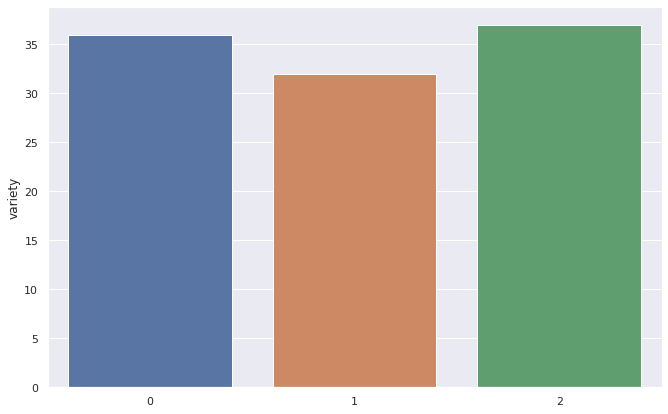

In [21]:
# Es de esperar que que mantenga las distribución de clases por el random uniforme
n_classes_train = y_train.value_counts()
sns.barplot(x = n_classes_train.index, y = n_classes_train)

In [22]:
# Convierto de pd.Dataframe -> np.ndarray
x_train, x_test, y_train, y_test = x_train.to_numpy(), x_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

## Selección de Modelos

Pruebo dos modelos: uno más tradicional/simple (**KNN**) y luego una **Red Neuronal**. El segundo

requiere probar con más hiperparámetros, a diferencia del primero que solo requiere cambiar el parametro k.


Luego comparo resultado y valido los dos métodos.

## KNN

In [23]:
# Es lo mismo que sklearn.metrics.accuracy_score. La diferencia es
# que de esta forma la función permite datos de tipo torch.Tensor
def accuracy(y_hat: Union[torch.Tensor, np.ndarray],
             y_true: Union[torch.Tensor, np.ndarray],
             promediar: bool = True) -> float:
  cant_correctos = (y_hat == y_true).sum()
  if isinstance(y_hat, torch.Tensor) and isinstance(y_true, torch.Tensor):
    return cant_correctos.item() / y_hat.numel() if promediar else cant_correctos.item()
  elif isinstance(y_hat, np.ndarray) and isinstance(y_true, np.ndarray):
    return cant_correctos / y_hat.size if promediar else cant_correctos
  else:
    raise ValueError(
        f'Inputs tienen que ser torch.Tensor o np.ndarray, se encontro {type(y_hat)}'
        )

In [24]:
# Verifico la función accuracy

# PyTorch
y_hat_pt = torch.tensor([4.0, 3.0], dtype=torch.float32)
y_pt = torch.tensor([4.0, 2.0], dtype=torch.float32)

assert accuracy(y_hat_pt, y_pt) == 0.5
assert accuracy(y_hat_pt, y_pt, promediar=False) == 1
# Numpy
y_hat_np = np.array([4.0, 3.0], dtype=np.float32)
y_np = np.array([4.0, 2.0], dtype=np.float32)
assert accuracy(y_hat_np, y_np) == 0.5
assert accuracy(y_hat_np, y_np, promediar=False) == 1

In [25]:
# Calculo el accuracy de test para `k` entre [1, 11]
k_accuracy = [accuracy_score(
    KNeighborsClassifier(n_neighbors=k, algorithm='brute', metric='euclidean').fit(x_train, y_train).predict(x_test),
    y_test) for k in range(1, 12, 2)]

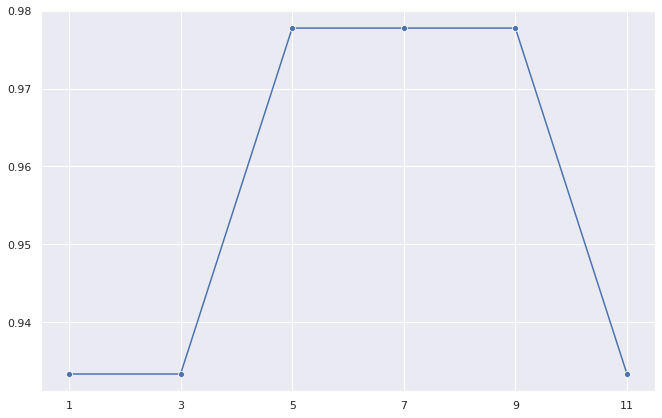

In [26]:
# Observo que valor de `k` da la mejor accuracy
x = np.arange(1, 12, 2)
ax = sns.lineplot(x=x, y=k_accuracy, marker='o')
ax.set(xticks=x)
plt.show()

In [27]:
# Como el dataset es chico no hay problema en usar
# el algoritmo brute que simeplemente compara una nueva
# entrada con todos los puntos ya existentes. Para medir
# la distancia usamos la distancia euclidiana: sqrt(sum((x - y)^2))
neighbors = KNeighborsClassifier(n_neighbors=5, algorithm='brute',
                             metric='euclidean').fit(x_train, y_train)

In [28]:
# Vemos que tan bien se ajusta a los datos de entrenamiento
y_hat = neighbors.predict(x_train)
accuracy(y_hat, y_train)

0.9619047619047619

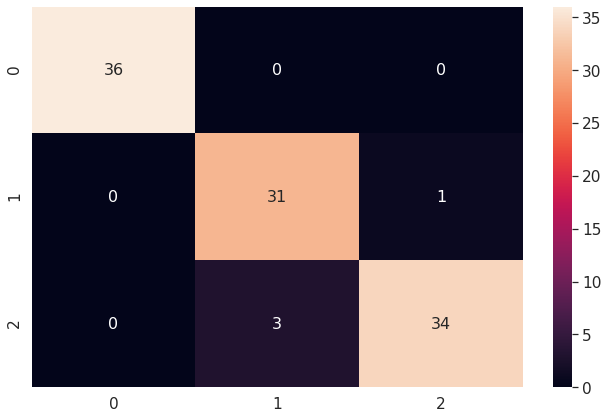

In [29]:
# Ploteamos una matriz de confusión
cm_train = confusion_matrix(y_train, y_hat)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_train, annot=True, annot_kws={"size": 16}) # font size

In [30]:
# Vemos que tan bien generaliza
y_hat_test = neighbors.predict(x_test)
accuracy(y_hat_test, y_test)

0.9777777777777777

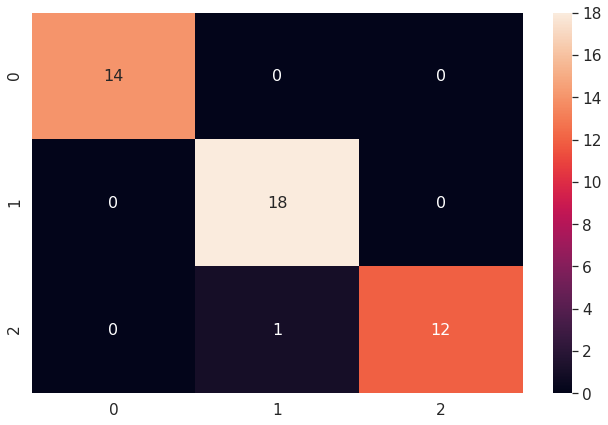

In [31]:
# Matriz de confusión para el test set
cm_test = confusion_matrix(y_test, y_hat_test)
sns.heatmap(cm_test, annot=True, annot_kws={"size": 16}) # font size

## Neural Net.

### Arquitectura del modelo

In [32]:
'''
Construye un Red Neuronal (Multi Layer Perceptron) en base a la lista layers.
El primer elemento de la lista siempre es el número features/datos de entrada
mientras que el último representa la cantidad de datos de salida. En este caso
el último siempre seria 3, por las clases: Setosa, Versicolor, Virginica.

Por ejemplo:
fc = FullyConnected(layers=[4, 32, 16, 32, 3])
Representa 4 features, 3 hidden-layers de {32, 16, 32} neuronas respectivamente
y 3 neuronas de salida. Por defecto no hay BatchNorm y Dropout.

Reciclado de mi otro repo:
https://github.com/ankandrew/DeepSudoku/blob/899bde9108974fafa610747069a920d26b5c6f75/deep_sudoku/model/block.py#L38
'''
class FullyConnected(nn.Module):
    def __init__(self,
                 layers: List,
                 batch_norm: bool = False,
                 dropout_rate: float = None,
                 activation: bool = True):
        super(FullyConnected, self).__init__()
        self.layers = layers
        self.batch_norm = batch_norm
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.fc = self.__make_fc()

    def forward(self, x):
        return self.fc(x)

    def __make_fc(self):
        layers = []
        penult_layer_i = len(self.layers) - 1
        for i in range(penult_layer_i):
            # Layers normales (tienen activación)
            if i < penult_layer_i - 1:
                # Batch norm ya incluye un termino bias entonces no hace
                # falta que nn.Linear lo incluya.
                layers.append(nn.Linear(self.layers[i], self.layers[i + 1],
                                        bias=not self.batch_norm))
                if self.batch_norm:
                    layers.append(nn.BatchNorm1d(self.layers[i + 1]))
                if self.activation:
                    layers.append(nn.ReLU())
                if self.dropout_rate:
                    layers.append(nn.Dropout(self.dropout_rate))
            # Para el último caso outputeamos los logits
            # (la combinación lineal sin función de activación)
            else:
                layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
        return nn.Sequential(*layers)

### Hiperparámetros

In [33]:
EPOCHS = 100
BATCH_SIZE = 16
LR = 0.01
DROP_OUT = False
BATCH_NORM = False
LAYERS = [4, 6, 6, 3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Preparación de datos para PyTorch

In [34]:
# Convierto de np.ndarray -> torch.Tensor
# Lo muevo a la cpu/gpu según el dispositivo elegido
x_train_tensor = torch.from_numpy(x_train).to(DEVICE)
y_train_tensor = torch.from_numpy(y_train).long().to(DEVICE)
x_test_tensor = torch.from_numpy(x_test).to(DEVICE)
y_test_tensor = torch.from_numpy(y_test).long().to(DEVICE)

# Creo un Dataset a partir de Tensores
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
# Creamos los loaders de train/test
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Entrenamiento

In [35]:
# Instancio el modelo
model = FullyConnected(LAYERS, batch_norm=BATCH_NORM, dropout_rate=DROP_OUT).to(DEVICE)
# Optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
# Función de coste, incluye: LogSoftmax + NLLLoss
# Por eso la predicción son logits (sin función de activación)
# y el ground truth se espera que este en el rango [0, número_clases-1]
loss = nn.CrossEntropyLoss()

In [36]:
def train_loop(model, train_loader, loss_fn, optimizer, device):
    for i, (x, y) in enumerate(train_loader):
        pred = model(x)  # Forward pass
        output = loss_fn(pred, y)  # Func. coste
        optimizer.zero_grad()  # Reseteo los gradientes (se acumulan por defecto)
        output.backward()  # Calculo dLoss/dParámetros
        optimizer.step()  # Actualizo parámetros
        # Cada 4 iteraciones muestro loss (para ver el progreso)
        if (i + 1) % 4 == 0:
            print(f'Loss {output.item():.5f}')

In [37]:
def test_loop(model, test_loader, loss_fn, device):
    model.eval()
    test_loss, correct = 0, 0
    n_samples = len(test_loader.dataset)
    # No calculamos el gradiente para el set de test
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            _, pred = pred.max(dim=1)
            correct += accuracy(y, pred, promediar=False)
        test_loss = test_loss / n_samples
        test_acc = correct / n_samples
        print(f'Test loss {test_loss:.5f}, Test accuracy {test_acc:.5f}')
    model.train()
    return test_loss, test_acc

In [38]:
# Loop de train/test
import copy

loss_history = []
acc_history = []
best_acc = 0.0
best_model = None
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}\n{"-"*30}')
    train_loop(model, train_loader, loss, optimizer, DEVICE)
    test_loss, test_acc = test_loop(model, test_loader, loss, DEVICE)
    if test_acc > best_acc:
      best_acc = test_acc
      best_model = copy.deepcopy(model)
    loss_history.append(test_loss)
    acc_history.append(test_acc)

Epoch 1
------------------------------
Loss 1.15326
Test loss 0.07328, Test accuracy 0.40000
Epoch 2
------------------------------
Loss 1.12628
Test loss 0.07295, Test accuracy 0.40000
Epoch 3
------------------------------
Loss 1.08222
Test loss 0.07275, Test accuracy 0.40000
Epoch 4
------------------------------
Loss 1.09381
Test loss 0.07276, Test accuracy 0.31111
Epoch 5
------------------------------
Loss 1.11404
Test loss 0.07275, Test accuracy 0.31111
Epoch 6
------------------------------
Loss 1.09332
Test loss 0.07279, Test accuracy 0.31111
Epoch 7
------------------------------
Loss 1.08556
Test loss 0.07271, Test accuracy 0.31111
Epoch 8
------------------------------
Loss 1.09258
Test loss 0.07273, Test accuracy 0.60000
Epoch 9
------------------------------
Loss 1.05673
Test loss 0.07251, Test accuracy 0.57778
Epoch 10
------------------------------
Loss 1.09630
Test loss 0.07229, Test accuracy 0.60000
Epoch 11
------------------------------
Loss 1.07850
Test loss 0.0717

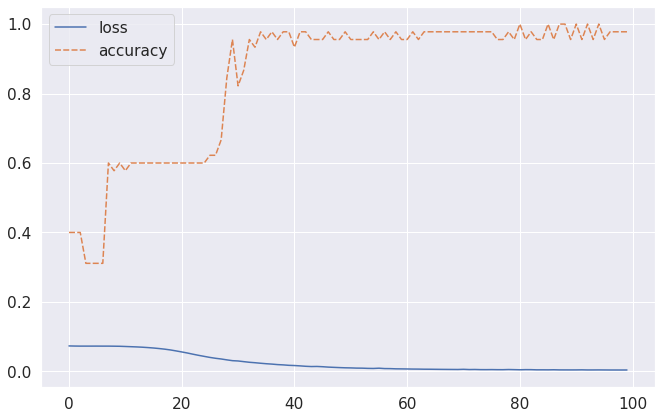

In [39]:
# Grafico el resultado del entrenamiento (en términos del test set)
metrics_history = pd.DataFrame(data = np.array([loss_history, acc_history]).T, 
                  index = np.arange(len(loss_history)), 
                  columns = ['loss', 'accuracy'])

sns.lineplot(data=metrics_history)

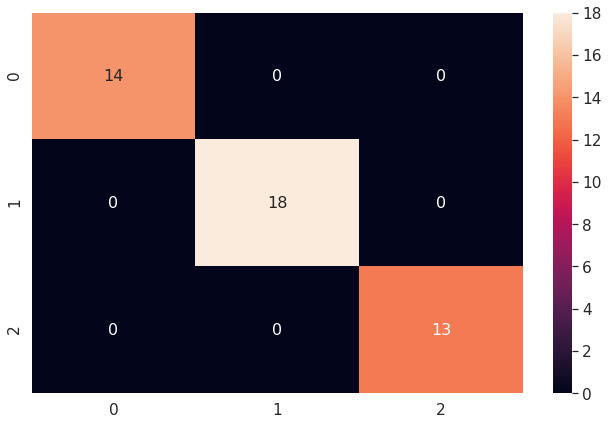

In [40]:
y_hat_test = best_model(x_test_tensor).argmax(dim=1).cpu().numpy()
# Matriz de confusión para el test set
cm_test_nn = confusion_matrix(y_test_tensor.cpu().numpy(), y_hat_test)
sns.heatmap(cm_test_nn, annot=True, annot_kws={"size": 16}) # font size

## Conclusiones

Realizamos un modelo más simple que llegó a **97.7%** de accuracy en el test-set (**KNN**) y por otro lado una **Red Neuronal** chica con dos hidden-layers de 6 neuronas, que llegó al **100%** de accuracy. En síntesis, ambos modelos logran una muy buena precisión para este dataset en particular.